In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

#%config InlineBackend.figure_format = "svg"

In [0]:
# Combine three weeks worth of MTA data from late April to early May

df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

df = df1.append([df2, df3])

In [232]:
df.head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,00:00:00,REGULAR,7026702,2382234
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,04:00:00,REGULAR,7026719,2382240
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,08:00:00,REGULAR,7026737,2382269
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,12:00:00,REGULAR,7026814,2382335
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,16:00:00,REGULAR,7027007,2382395


In [0]:
test = df[(df['TIME'] != '00:00:00') & (df['TIME'] != '04:00:00') & (df['TIME'] != '08:00:00') & (df['TIME'] != '12:00:00')  & (df['TIME'] != '16:00:00') & (df['TIME'] != '20:00:00')]

In [238]:
len(test)

304249

In [0]:
# Data Cleaning 

df.columns = df.columns.str.strip()

df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format="%m/%d/%Y %H:%M:%S")

df.drop(columns=['DATE', 'TIME'], inplace=True)

df['DAY'] = df['DATETIME'].dt.day_name()

# Each turnstile can be indentified by a combination of the UNIT and SCP. Grouping by these two features allows us to get accurate
# entry and exit counts. 

df['ENTRY COUNT'] = df.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
df['EXIT COUNT'] = df.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())


In [31]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATETIME,DAY,ENTRY COUNT,EXIT COUNT
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026702,2382234,2019-04-20 00:00:00,Saturday,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026719,2382240,2019-04-20 04:00:00,Saturday,17.0,6.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026737,2382269,2019-04-20 08:00:00,Saturday,18.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026814,2382335,2019-04-20 12:00:00,Saturday,77.0,66.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027007,2382395,2019-04-20 16:00:00,Saturday,193.0,60.0


In [32]:
df.describe()

,ENTRIES,EXITS,ENTRY COUNT,EXIT COUNT
count,6.148020e+05,6.148020e+05,6.099380e+05,6.099380e+05
mean,4.084381e+07,3.341919e+07,9.933010e+02,1.860043e+03
std,2.096598e+08,1.933731e+08,3.364400e+06,3.064132e+06
min,0.000000e+00,0.000000e+00,-1.835264e+09,-1.359348e+09
25%,3.494502e+05,1.438178e+05,9.000000e+00,8.000000e+00
50%,2.174896e+06,1.244878e+06,7.000000e+01,5.100000e+01
75%,6.773246e+06,4.590770e+06,2.330000e+02,1.620000e+02
max,2.129355e+09,2.124143e+09,1.126553e+09,1.078346e+09


Both **ENTRY COUNT** AND **EXIT COUNT** have negative values and for the min and crazy high values for the max. This is in part due to complications such as turnstiles being reset, changed, etc.

In [0]:
# Dropping rows with irrational values

df = df[(df['ENTRY COUNT'] >= 0) & (df['EXIT COUNT'] >= 0)]

In [0]:
Q1_entry = df['ENTRY COUNT'].quantile(0.25)
Q3_entry = df['ENTRY COUNT'].quantile(0.75)
IQR_entry = Q3_entry - Q1_entry

Q1_exit = df['EXIT COUNT'].quantile(0.25)
Q3_exit = df['EXIT COUNT'].quantile(0.75)
IQR_exit = Q3_exit - Q1_exit

entry_bound = Q3_entry + 1.5 * IQR_entry
exit_bound = Q3_exit + 1.5 * IQR_exit

In [35]:
df.describe()

,ENTRIES,EXITS,ENTRY COUNT,EXIT COUNT
count,6.026730e+05,6.026730e+05,6.026730e+05,6.026730e+05
mean,2.786367e+07,2.016885e+07,6.446536e+03,6.742399e+03
std,1.588909e+08,1.360172e+08,2.110708e+06,2.269092e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.366980e+05,1.389650e+05,1.000000e+01,8.000000e+00
50%,2.121450e+06,1.207749e+06,7.200000e+01,5.100000e+01
75%,6.466613e+06,4.418113e+06,2.350000e+02,1.640000e+02
max,2.115823e+09,2.037820e+09,1.126553e+09,1.078346e+09


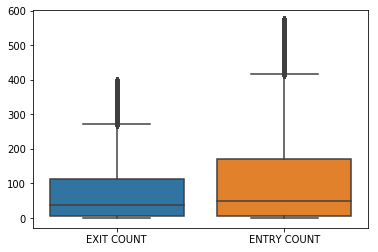

In [36]:
IQR_df = df.copy()
IQR_df = df[(df['ENTRY COUNT'] < entry_bound) & (df['EXIT COUNT'] < exit_bound)]
ax = sns.boxplot(data=IQR_df[['EXIT COUNT', 'ENTRY COUNT']])

One approach to remove crazy high values is to use the IQR to remove outliers. However, the boxplot above illustrates that there a considerable amount of outliers. The most popular stations can have significantly higher traffic so removing these outliers can negatively affect our analysis to determine the most popular stations. Instead of using the IQR to remove outliers, we chose to set an upper limit of 15,000 entries or exits in a four hour period.

In [57]:
df = df[(df['ENTRY COUNT'] < 15000 ) & (df['EXIT COUNT'] < 15000)]
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATETIME,DAY,ENTRY COUNT,EXIT COUNT
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026719,2382240,2019-04-20 04:00:00,Saturday,17.0,6.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026737,2382269,2019-04-20 08:00:00,Saturday,18.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026814,2382335,2019-04-20 12:00:00,Saturday,77.0,66.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027007,2382395,2019-04-20 16:00:00,Saturday,193.0,60.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027293,2382427,2019-04-20 20:00:00,Saturday,286.0,32.0


Finally, we grouped data by **STATION** and **LINENAME** because some big stations have different exits or locations depending on the train line.

In [58]:
final = df.groupby(['STATION', 'LINENAME']).agg({'ENTRY COUNT' : 'sum', 'EXIT COUNT' : 'sum'})
final.reset_index(inplace=True)
final['TOTAL TRAFFIC'] = final['ENTRY COUNT'] + final['EXIT COUNT']
top = final.sort_values('EXIT COUNT', ascending=False).head(10)
top

,STATION,LINENAME,ENTRY COUNT,EXIT COUNT,TOTAL TRAFFIC
311,GRD CNTRL-42 ST,4567S,2639828.0,2326228.0,4966056.0
89,34 ST-HERALD SQ,BDFMNQRW,2129151.0,2011772.0,4140923.0
93,34 ST-PENN STA,ACE,1527514.0,1383212.0,2910726.0
102,42 ST-PORT AUTH,ACENQRS1237W,1439824.0,1209977.0,2649801.0
446,TIMES SQ-42 ST,1237ACENQRSW,1261544.0,1207689.0,2469233.0
27,14 ST-UNION SQ,LNQR456W,1330276.0,1199564.0,2529840.0
106,47-50 STS ROCK,BDFM,1064730.0,1099616.0,2164346.0
301,FULTON ST,2345ACJZ,1103759.0,1089165.0,2192924.0
125,59 ST COLUMBUS,ABCD1,1099081.0,908617.0,2007698.0
402,PATH NEW WTC,1,956183.0,864703.0,1820886.0


In [60]:
final[final['STATION'] == '34 ST-PENN STA']

,STATION,LINENAME,ENTRY COUNT,EXIT COUNT,TOTAL TRAFFIC
91,34 ST-PENN STA,123,632692.0,659708.0,1292400.0
92,34 ST-PENN STA,123ACE,885450.0,764064.0,1649514.0
93,34 ST-PENN STA,ACE,1527514.0,1383212.0,2910726.0


# Geolocation Section

In [39]:
locdf = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/Stations.csv")
locdf.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan


In [0]:
# names of the top 10 stations reformatted to match "Stop Name" in locdf

names = ['Grand Central - 42 St', 
         '34 St - Herald Sq', 
         '34 St - Penn Station', 
         '42 St - Port Authority Bus Terminal', 
         'Times Sq - 42 St',
         'Union Sq - 14 St',
         '47-50 Sts - Rockefeller Ctr',
         'Fulton St',
         '59 St - Columbus Circle',
         'World Trade Center'
         ]

In [41]:
# Data Cleaning

loc_subset = locdf[['Stop Name', 'GTFS Latitude', 'GTFS Longitude' ]]
loc_subset = loc_subset[loc_subset['Stop Name'].isin(names)]
loc_subset = loc_subset.reset_index(drop=True)

loc_subset.drop_duplicates(subset = "Stop Name", keep = 'first', inplace = True)

loc_subset


,Stop Name,GTFS Latitude,GTFS Longitude
0,Times Sq - 42 St,40.754672,-73.986754
1,34 St - Herald Sq,40.749567,-73.987950
2,Fulton St,40.710374,-74.007582
3,Union Sq - 14 St,40.734789,-73.990730
4,59 St - Columbus Circle,40.768296,-73.981736
5,42 St - Port Authority Bus Terminal,40.757308,-73.989735
6,34 St - Penn Station,40.752287,-73.993391
7,World Trade Center,40.712582,-74.009781
9,47-50 Sts - Rockefeller Ctr,40.758663,-73.981329
16,Grand Central - 42 St,40.751776,-73.976848


In [228]:

map_osm = folium.Map(location=[40.7580, -73.9855], zoom_start=12.2)

loc_subset.apply(lambda row:folium.CircleMarker(location=[row["GTFS Latitude"], row["GTFS Longitude"]],
                                              radius=2, color='#1A10DE', fill_color= 'red')
                                             .add_to(map_osm), axis=1)

map_osm

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/')

In [0]:
tech = pd.read_csv("Tech_Companies_NYC.csv")

In [65]:
tech.head(15)

,Company Name,Address,Address2,City,Category Name,URL
0,"""Document Prep-Program""'",' - ',' - ',' - ',NaN,NaN
1,"""More than just Figleaves'",' - ',' - ',' - ',NaN,NaN
2,#Fit4ME',' - ',' - ',' - ',NaN,NaN
3,'brellaBox',' - ',' - ',' - ',NaN,NaN
4,'wichcraft',' - ',' - ',' - ',NaN,NaN
5,(GFree)dom',' - ',' - ',' - ',NaN,NaN
6,0s&1s Novels',' - ',' - ',' - ',NaN,NaN
7,1 Knickerbocker',' - ',' - ',' - ',NaN,NaN
8,1 Main Street Capital',' - ',' - ',' - ',NaN,NaN
9,10 Speed Labs','1239 Broadway','Penthouse','New York',NaN,NaN


In [0]:
tech = tech[tech['Address'].str.len() > 5]

In [128]:
tech

,Company Name,Address,Address2,City,Category Name,URL,Final
9,10 Speed Labs','1239 Broadway','Penthouse','New York',NaN,NaN,"1239 Broadway, New York"
17,1800Postcards.com','121 Varick Street','4th Floor','New York',NaN,NaN,"121 Varick Street, New York"
20,1938 News','1 Astor Pl',' - ','New York',NaN,NaN,"1 Astor Pl, New York"
21,1DocWay',"'483 Broadway, Floor 2, New York, NY 10013'","'483 Broadway, Floor 2'",'New York',NaN,NaN,"483 Broadway, Floor 2, New York, NY 10013, New..."
27,1stdibs.com','51 Astor Place','Third Floor','New York',NaN,NaN,"51 Astor Place, New York"
28,20x200','6 Spring Street',' - ','New York',NaN,NaN,"6 Spring Street, New York"
30,24symbols','42 West 24th Street ',' - ','New York',NaN,NaN,"42 West 24th Street , New York"
35,2U (aka 2tor)',"'60 Chelsea Piers, Suite 6020'",' - ','New York',NaN,NaN,"60 Chelsea Piers, Suite 6020, New York"
36,2findLocal','2637 E 27th St',' - ','New York',NaN,NaN,"2637 E 27th St, New York"
39,33across',"'229 West 28th Street, 12th Fl'",' - ','New York',NaN,NaN,"229 West 28th Street, 12th Fl, New York"


In [0]:
!pip install geopandas


In [76]:

import geopandas as gpd
from geopandas.tools import geocode

tech.loc[:10]

,Company Name,Address,Address2,City,Category Name,URL
9,10 Speed Labs','1239 Broadway','Penthouse','New York',NaN,NaN


In [0]:
tech['Final'] = tech['Address'].map(str) + ', New York'
tech['Final'] = tech['Final'].str.replace("'", "")


In [215]:
tech.head()
#fire = tech.sample(200, random_state=27)
fire = tech.sample(500, random_state=24)
fire

,Company Name,Address,Address2,City,Category Name,URL,Final
899,CariCorps','601 West 26th Street','Suite 325','New York',NaN,NaN,"601 West 26th Street, New York"
1865,Flow',"'20 Jay Street, Suite 622, Brooklyn, NY 11201'",' - ',' - ',NaN,NaN,"20 Jay Street, Suite 622, Brooklyn, NY 11201, ..."
1041,Clothes Horse','110 E 23rd St 8th Floor',' - ','New York',NaN,NaN,"110 E 23rd St 8th Floor, New York"
5173,The Tiny Rebels','50 Hope St.',' - ','Brooklyn',NaN,NaN,"50 Hope St., New York"
1916,Fox News Digital','1211 Avenue of the Americas','14th Floor','New York',NaN,NaN,"1211 Avenue of the Americas, New York"
2746,Krate',"'44-02 23rd St, Suite 516'",' - ','Long Island City',NaN,NaN,"44-02 23rd St, Suite 516, New York"
334,Arc90','747 3rd Ave','30th Floor','New York',NaN,NaN,"747 3rd Ave, New York"
3812,PeoplePerHour','175 Varick Street','4th Floor','New York',NaN,NaN,"175 Varick Street, New York"
4702,Sonic Notify (Signal360)',"'251 5TH AVENUE, 6TH FLOOR'",' - ','New York',NaN,NaN,"251 5TH AVENUE, 6TH FLOOR, New York"
2835,LetsWombat','1500 Broadway','802','New York',NaN,NaN,"1500 Broadway, New York"


In [113]:
!pip install geopy

In [0]:
from geopy.geocoders import Nominatim

In [0]:
geolocator = Nominatim(user_agent="agent")

In [0]:
fire['city_coord'] = fire['Final'].apply(geolocator.geocode)
fire.dropna(subset=['city_coord'], inplace=True)

In [0]:
fire['lat'] = fire['city_coord'].apply(lambda x: (x.latitude))
fire['long'] = fire['city_coord'].apply(lambda x: (x.longitude))

In [218]:
len(fire)

401

In [221]:

fire.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]],tiles="Mapbox Bright", 
                                              radius=1, color='red', fill_color = 'red')
                                             .add_to(map_osm), axis=1)

map_osm

In [229]:
df[ (df['SCP'] != '02-00-00') & ]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATETIME,DAY,ENTRY COUNT,EXIT COUNT
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026719,2382240,2019-04-20 04:00:00,Saturday,17.0,6.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026737,2382269,2019-04-20 08:00:00,Saturday,18.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026814,2382335,2019-04-20 12:00:00,Saturday,77.0,66.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027007,2382395,2019-04-20 16:00:00,Saturday,193.0,60.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027293,2382427,2019-04-20 20:00:00,Saturday,286.0,32.0


In [239]:
df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,00:00:00,REGULAR,7026702,2382234
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,04:00:00,REGULAR,7026719,2382240
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,08:00:00,REGULAR,7026737,2382269
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,12:00:00,REGULAR,7026814,2382335
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,16:00:00,REGULAR,7027007,2382395
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,20:00:00,REGULAR,7027293,2382427
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/21/2019,00:00:00,REGULAR,7027457,2382455
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/21/2019,04:00:00,REGULAR,7027469,2382456
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/21/2019,08:00:00,REGULAR,7027479,2382471
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/21/2019,12:00:00,REGULAR,7027568,2382520


In [244]:
x = '05:00:00'

'00:00:00' < x < '09:00:00'

True